# Introduction to Ecological Inference (EI)

Start here if you'd like to use PyEI but are newer to ecological inference in general.

If you are already familiar with ecological inference and would like to understand how to use PyEI, consider starting with the PyEI Overview notebook instead.

## What is ecological inference?

We now describe the question that ecological inference seeks to answer in the context of estimating racially polarized voting. Suppose that you are interested in learning about the voting trends in some polity that has $N$ precincts. For each of those precincts, you know (from Census data) the proportion of voters who belong to a particular demographic or racial group, *and* you know (from Election returns) the voting results in that precinct - how many voters voted for each candidate. What is harder to know is how each demographic group voted - e.g. what percent of Black voters voted for Candidate A? what percent of White voters voted for Candidate B? These questions are vital to assessing electoral opportunity in the context of the Voting Rights Act (VRA).  Ecological inference seeks to estimate answers to those kinds of questions.

Put another way, we can imagine we have a series of $N$ tables, one for each precinct. We know the "marginal" values, but not the values on the interior of the table - we would like to infer those.
In the ecological inference literature you will read about the "2 by 2" and "$r$ by $c$" case. The "2 by 2" case refers to when we have only two demographic groups of interest -- one group and its complement, as well as only one candidate or voting outcome of interest (e.g. candidate A vs. everyone else, or voting vs. not voting).

For example, if we have $r$=3 groups, and $c$=2 candidates, then for each precinct we might have a table with known marginal values that looks something like the following:

|  Precinct n  | Candidate A | Candidate B |               |
| :---        | :---:        |    :----:   |          ---: |
| Group 1     |  ?          | ?       |  0.6   |
| Group 2     | ?           | ?       | 0.2      |
| Group 3     | ?     | ?      | 0.2   |
|    | 0.7   | 0.3       |       |

In this example, we know that in the nth precinct, Candidate A got 70% of the vote and Candidate B got 30% of the vote. We also know that 60% of the voters were in group 1, 20% in group 2, and 20% in group 3. What we would *like* to say is something about the polity-wide (i.e. across voters in all the relevant precincts) support of, say, Group 1 for Candidate A, or Group 3 for Candidate B. 

Ecological inference yields estimates of these quantities of interest, allowing for conclusions such as, "Under the assumptions of (X ecological inference model), we estimate that across the polity (district, state, etc.), Y% of voters in Group 2 voted for Candidate B."

It is important to recognize that these are estimates! The estimates come from fitting statistical models to data. Many ecological inference methods also give us ways of quantifying uncertainty, so that we can refine our conclusions to statements of the form, "Under the assumptions of (X ecological inference model), there is a 95% probability that between Y% and Z% of voters in Group 2 voted for Candidate B." However, all ecological inference methods depend on specific models and assumptions that may or may not be appropriate for the data at hand, and thus it *is* possible for the results of ecological inference to place high probability on a value that is incorrect. Ecological inference is a challenging statistical problem.

The problem of ecological inference is relevant in several fields, such as epidemiology, sociology, and political science. Our interest comes from the use of ecological inference in voting rights cases, as a tool to help investigate racially polarized voting. Thus, the examples and terminology in PyEI will refer to voting, although the library could be used to perform ecological inference in other contexts.

## What kind of data do I need for ecological inference?

Ecological inference methods require the following data be provided *for each precinct*:
- the fraction of the population of interest in each of the $r$ demographic groups (these fractions should sum to 1 within each precinct)
- the fraction of the population of interest voting for each of the $c$ candidates or voting outcomes (these franction should also sum to 1 within each precinct)

And for many methods we also need:
- the number of people in the population of interest of each precinct

Gathering this data is often trickier than you might think. "Population of interest" may sound simple, but it's not always straightforward to decide on (and in practice often reflects the "population that we have data about" more than  the "population we are specifically interested in analyzing"). Ideally our "population of interest" would be "people who actually voted", however, in most instances we do not know the exact demographic breakdown of these voters.  Instead we often use a proxy "population of interest" such as "Voting Age Population."  Then ecological inference methods would expect both the demographic-group fractions and voting-outcome fractions to be expressed as fractions of that same population of interest - Voting Age Population. 

So, first we'd need percentage of the Voting Age Population in each demographic group for each precinct.  The Census provides demographic breakdowns of Voting Age Populations for geographic units down to the Census Block level, which can be aggregated up to the precinct level (which itself requires either a precinct shapefile or a Block-Assignment File).  

Then we'd need the fraction of Voting Age Population associated with each voting outcome -- but since these fractions are assumed to sum to 1, we must account for the fraction of the Voting Age Population that did not vote in that election.  That is, we cannot just provide the percentage of votes that went to Candidate A and Candidate B, even if there are only two candidates, since those two options probably won't cover the whole Voting Age Population unless everyone in this "population of interest" actually voted. So, we might expand our set of voting outcomes to, e.g. $c$=3 options: Candidate A, Candidate B, Abstain.

There's a lot more to say and investigate about the impact of these kinds of choices and the associated challenges, but it's outside the scope of this quick introduction to our library.

#### Example

PyEI includes tools for accessing some example datasets. Here we have data that gives the proportion of voters in each of $r$=3 groups (`ind`, `e_asian`, `non_asian`) for each of $c$=3 candidates (`Hardy`, `Kolstad`, `Nadeem`). There are $N$=42 precincts in this dataset. We can examine the shape of the input data and confirm that the demographic-group percentages and voting-outcome percentages within each precinct sum to 1.


In [4]:
from pyei.data import Datasets
import numpy as np

santa_clara_data = Datasets.Santa_Clara.to_dataframe()

group_fractions_rbyc = np.array(santa_clara_data[['pct_ind_vote', 'pct_e_asian_vote', 'pct_non_asian_vote']]).T
votes_fractions_rbyc = np.array(santa_clara_data[['pct_for_hardy2', 'pct_for_kolstad2', 'pct_for_nadeem2']]).T
precinct_pops = np.array(santa_clara_data['total2'])

print(group_fractions_rbyc.shape) # shape: r x num_precincts
print(votes_fractions_rbyc.shape) # shape c x num_precincts
print(precinct_pops.shape) # shape: num_precincts
#print(group_fractions_rbyc.sum(axis=0))
#print(votes_fractions_rbyc.sum(axis=0))

(3, 42)
(3, 42)
(42,)


## What does it mean that most of the models supported by PyEI are Bayesian models and that inference proceeds via sampling methods, and what does that mean for interpreting the results?

At a basic level, these Bayesian models each make some assumptions about various parameters (like the percentage of Group 1 who voted for Candidate A in Precinct n), how likely they are a priori to take different values, and how these parameters relate both to each other and to observed data (like the percentage of the population of interest who voted for Candidate A in Precinct n). We then want to compute the probability of these parameters taking on different values given the observed data - their *posterior probability*. 


We're not *sure* about the value of the parameters---even after seeing the data--we just have an idea of which values are more and less likely. Despite this lack of certainty, the kind of probabilistic information that we have is very helpful. It allows us to make estimates like "there is a 95% probability that the support of Group 1 for Candidate A is between 0.25 and 0.46 (under the assumptions of the model)".

Many of the plotting functions in PyEI give density plots so that you can see the range of possible values for a given parameter and which of these values are estimated to be more or less likely, given the model and the data. In the example below, the posterior means of the support for Candidate Hardy are estimated to be .81 for e_asian and .24 for non-e_asian. Looking at the plot tells us more than the posterior means, however; we can see, for example, that we're less sure about the level of e_asian support for Hardy than we are about level of non-e-asian support for Hardy -- there's a larger range of similarly probable values for the e_asian support.

Sometimes we really want to summarize with just one number our estimate of, say, the support of Group 1 for Candidate A. In this case, we might use the posterior mean -- just remember there are other potentially appropriate options for this point estimate (like the median or the mode), and that it is summarizing a distribution about which we actually have more information.

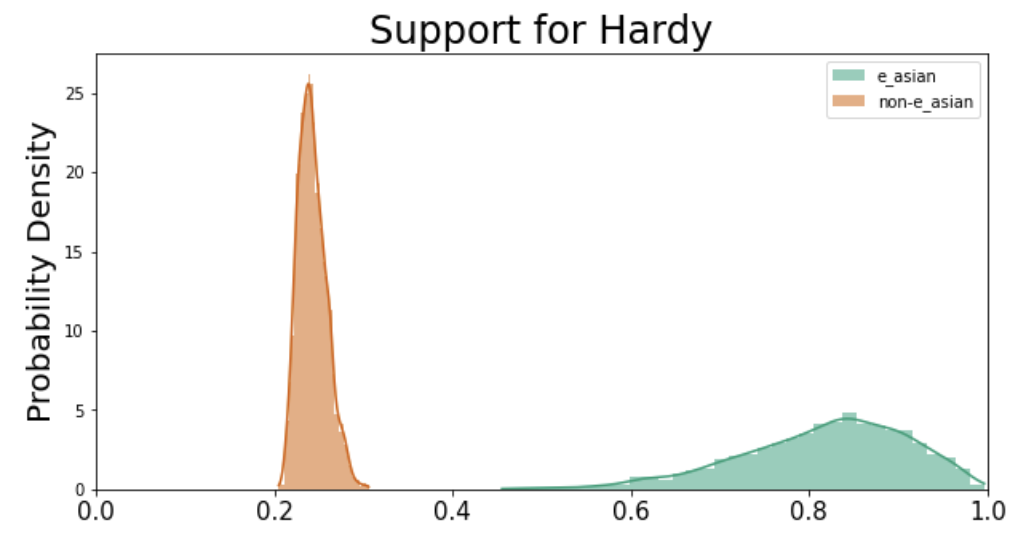

In PyEI and other existing tools for ecological inference, the posterior probability distributions of the sort visualized above are obtained via MCMC sampling. That means that in order to learn about the posterior distributions of the parameters, we use methods that yield *samples* from the posterior probability distributions of all of the parameters. The idea of sampling is like learning about the distribution of how a die lands by rolling the die many times and observing what happens -- we can use a finite set of observations to estimate that the probability of rolling a two is about 1/6, if we count that about 1/6 of our rolls were twos. We use MCMC methods to generate, say, 1000 samples from the posterior distribution (or some other appropriately large number of samples). If we have 1000 samples from the posterior distribution, and 813 of them are greater than X, we can estimate that the posterior probability that the parameter is above X is 81.3%. PyEI includes a number of built-in methods for summarizing the posterior distributions, but the samples themselves are directly accessible as well, and it can be helpful to know that they are there.  

There is LOTS more to say about Bayesian modeling, and of course also much to say specifically about the models for ecological inference that are implemented in PyEI! There are also plenty of things that can go wrong with this kind of sampling - for example, you may see alerts about problems during sampling that may indicate that the posterior distribution is not adequately being sampled from and we should be concerned (although these issues arise across ecological inference implementations, PyEI may be more vocal than existing tools about alerting you to such problems). This overview is not meant to be comprehensive, but just to give a bit of helpful background as you dig deeper.